# query description

#### The query would sum up the quantity of products being ordered in the current orders according to their category and then display them using bar plot in order from most selling to least selling product. 

#### Then we have another graph just beneath it, which will sum up the product category wise quantities. The stores and daily_inventory_levels collection are respectively used for fresh and other category. 

#### This means that if someone uses this query could see the best performing products in the current orders, and then see which products are selling the best, and also can see a graph which tells the person to see what is the inventory levels are looking for that date for which we are seeing the orders, which would mean they can make crucial decisions such as stocking more for best selling products and stocking less for least selling products.

In [2]:
import pymongo
import pprint
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import logging

In [3]:
# making connection string with the cluster in which our database is stored
conn_str = "your conneciton string here" 
# this string is removed after running the query to keep the cluster and
# credentials of the group private.
try:
    client = pymongo.MongoClient(conn_str)
except:
    print("error: " + Exception)


In [4]:
# storing the database name in the variable 'db' to use it easily
db = client["AMAZONE"]

In [5]:
# Set up logging
# This will help in logging the errors that someone may face and displaying them to the caller of the query
logging.basicConfig(level=logging.ERROR)
log = logging.getLogger(__name__)


In [6]:

# storing the product IDs for "fresh" category from the products collection into a list
fresh_category_products_ids = db.products.distinct("_id", {"category": "fresh"})

# storing the product IDs for "other" category from the products collection into a list
other_category_products_ids = db.products.distinct("_id", {"category": "other"})

# this function performs all of the aggregation pipelines and the plots while handling erros
def generate_product_performance_plot(date):

    # Aggregation pipeline for fresh category products inventory levels that is in stores collection
    fresh_products_inventory_performance_pipeline = [
        {
            "$match": {
                "location.type": "Point", 
                "available_groceries.product_id": {"$in": fresh_category_products_ids}
            }
        },
        {
            "$unwind": "$available_groceries"
        },
        {
            "$match": {
                "available_groceries.product_id": {"$in": fresh_category_products_ids}
            }
        },
        {
            "$group": {
                "_id": "$available_groceries.product_id",
                "total_quantity": {"$sum": "$available_groceries.quantity"}
            }
        },
        {
            "$sort": {"total_quantity": -1}
        },
    ]

    # Aggregation pipeline for others category products inventory levels that is in daily_inventory_levels collection
    other_products_inventory_performance_pipeline = [
        {
            "$match": {
                "date": date,
                "storage_warehouses.products.product_id": {"$in": other_category_products_ids}
            }   
        },
        {
            "$unwind": "$storage_warehouses"
        },
        {
            "$unwind": "$storage_warehouses.products"
        },
        {
            "$match": {
                "storage_warehouses.products.product_id": {"$in": other_category_products_ids}
            }
        },
        {
            "$group": {
                "_id": "$storage_warehouses.products.product_id",
                "total_quantity": {"$sum": "$storage_warehouses.products.quantity"}
            }
        },
        {
            "$sort": {"total_quantity": -1}
        },
    ]


   # Executing the pipelines using try except to take error handling into account
    try:
        fresh_inventory_result = db.stores.aggregate(fresh_products_inventory_performance_pipeline)
    except Exception as e:
        log.error(f"Error in MongoDB aggregation for fresh inventory in stores: {e}")
        return

    try:
        other_inventory_result = db.daily_inventory_levels.aggregate(other_products_inventory_performance_pipeline)
    except Exception as e:
        log.error(f"Error in MongoDB aggregation for other inventory in daily_inventory_levels: {e}")
        return
    

    # Aggregation pipeline for fresh category products performance in current orders that is taken from customers collection
    fresh_orders_pipeline = [
        {
            "$match": {
                "current_orders.date": date,
                "current_orders.items.product_id": {"$in": fresh_category_products_ids}
            }
        },
        {
            "$unwind": "$current_orders"
        },
        {
            "$unwind": "$current_orders.items"
        },
        {
            "$match": {
                "current_orders.items.product_id": {"$in": fresh_category_products_ids}
            }
        },
        {
            "$group": {
                "_id": "$current_orders.items.product_id",
                "total_quantity": {"$sum": "$current_orders.items.quantity"}
            }
        },
        {
            "$sort": {"total_quantity": -1}
        },
    ]

    # Aggregation pipeline for others category products performance in current orders that is taken from customers collection
    other_orders_pipeline = [
        {
            "$match": {
                "current_orders.date": date,
                "current_orders.items.product_id": {"$in": other_category_products_ids}
            }
        },
        {
            "$unwind": "$current_orders"
        },
        {
            "$unwind": "$current_orders.items"
        },
        {
            "$match": {
                "current_orders.items.product_id": {"$in": other_category_products_ids}
            }
        },
        {
            "$group": {
                "_id": "$current_orders.items.product_id",
                "total_quantity": {"$sum": "$current_orders.items.quantity"}
            }
        },
        {
            "$sort": {"total_quantity": -1}
        },
    ]

    # Executing the  pipelines while handling erros
    try:
        fresh_orders_result = db.customers.aggregate(fresh_orders_pipeline)
    except Exception as e:
        log.error(f"Error in MongoDB aggregation for fresh category in current orders: {e}")
        return

    try:
        other_orders_result = db.customers.aggregate(other_orders_pipeline)
    except Exception as e:
        log.error(f"Error in MongoDB aggregation for other category in current orders: {e}")
        return
    
    # Setting grid using seaborn for the plots
    sns.set(style="whitegrid")

    # Extracting data from our aggregation pipelines that we executed, to get data labelled in variables for plotting purposes
    try:
        fresh_inventory_data = [{"product_id": entry["_id"], "total_quantity": entry["total_quantity"]} for entry in fresh_inventory_result]
    except Exception as e:
        log.error(f"Error extracting data for plotting of Fresh Category products inventory information: {e}")
        return
    
    try:
        other_inventory_data = [{"product_id": entry["_id"], "total_quantity": entry["total_quantity"]} for entry in other_inventory_result]
    except Exception as e:
        log.error(f"Error extracting data for plotting of Other Category products inventory information: {e}")
        return
    
    try:
        fresh_orders_data = [{"product_id": entry["_id"], "total_quantity": entry["total_quantity"]} for entry in fresh_orders_result]
    except Exception as e:
        log.error(f"Error extracting data for plotting of Fresh Category Products Performance in Current Orders: {e}")
        return
    
    try:
        other_orders_data = [{"product_id": entry["_id"], "total_quantity": entry["total_quantity"]} for entry in other_orders_result]
    except Exception as e:
        log.error(f"Error extracting data for plotting of Other Category Products Performance in Current Orders: {e}")
        return
    
    
    # Plotting for Fresh Category Products
    try:

        fig, axes = plt.subplots(2, 1, figsize=(15, 10))

        bar1 = axes[0].bar(range(len(fresh_orders_data)), [entry["total_quantity"] for entry in fresh_orders_data], color=sns.color_palette("colorblind"), alpha=0.7, edgecolor='black')
        axes[0].set_title(f'Fresh Products Performance - Current Orders ({date})')
        axes[0].set_ylabel('Total Quantity')


        for rect in bar1:
            height = rect.get_height()
            axes[0].annotate(f'{int(height)}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), 
                            textcoords="offset points", ha='center', va='bottom')


        axes[0].set_xticks(range(len(fresh_orders_data)))
        axes[0].set_xticklabels([entry["product_id"] for entry in fresh_orders_data], rotation=45, ha='right', rotation_mode='anchor')

        bar2 = axes[1].bar(range(len(fresh_inventory_data)), [entry["total_quantity"] for entry in fresh_inventory_data], color=sns.color_palette("colorblind"), alpha=0.7, edgecolor='black')
        axes[1].set_title(f'Fresh Products - Inventory Levels Across all stores ({date})')
        axes[1].set_xlabel('Product ID')
        axes[1].set_ylabel('Total Quantity')


        for rect in bar2:
            height = rect.get_height()
            axes[1].annotate(f'{int(height)}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), 
                            textcoords="offset points", ha='center', va='bottom')

 
        axes[1].set_xticks(range(len(fresh_inventory_data)))
        axes[1].set_xticklabels([entry["product_id"] for entry in fresh_inventory_data], rotation=45, ha='right', rotation_mode='anchor')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        log.error(f"Error in plotting for Fresh Category Products: {e}")
        return


    # Plotting for Other Category Products
    try:

        fig, axes = plt.subplots(2, 1, figsize=(15, 10))


        bar3 = axes[0].bar(range(len(other_orders_data)), [entry["total_quantity"] for entry in other_orders_data], color=sns.color_palette("colorblind"), alpha=0.7, edgecolor='black')
        axes[0].set_title(f'Other Category Products Performance - Current Orders ({date})')
        axes[0].set_ylabel('Total Quantity')


        for rect in bar3:
            height = rect.get_height()
            axes[0].annotate(f'{int(height)}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), 
                            textcoords="offset points", ha='center', va='bottom')


        axes[0].set_xticks(range(len(other_orders_data)))
        axes[0].set_xticklabels([entry["product_id"] for entry in other_orders_data], rotation=45, ha='right', rotation_mode='anchor')

        bar4 = axes[1].bar(range(len(other_inventory_data)), [entry["total_quantity"] for entry in other_inventory_data], color=sns.color_palette("colorblind"), alpha=0.7, edgecolor='black')
        axes[1].set_title(f'Other Category Products - Inventory Levels Across all stores ({date})')
        axes[1].set_xlabel('Product ID')
        axes[1].set_ylabel('Total Quantity')


        for rect in bar4:
            height = rect.get_height()
            axes[1].annotate(f'{int(height)}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), 
                            textcoords="offset points", ha='center', va='bottom')


        axes[1].set_xticks(range(len(other_inventory_data)))
        axes[1].set_xticklabels([entry["product_id"] for entry in other_inventory_data], rotation=45, ha='right', rotation_mode='anchor')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        log.error(f"Error in plotting for Other category Products: {e}")
        return






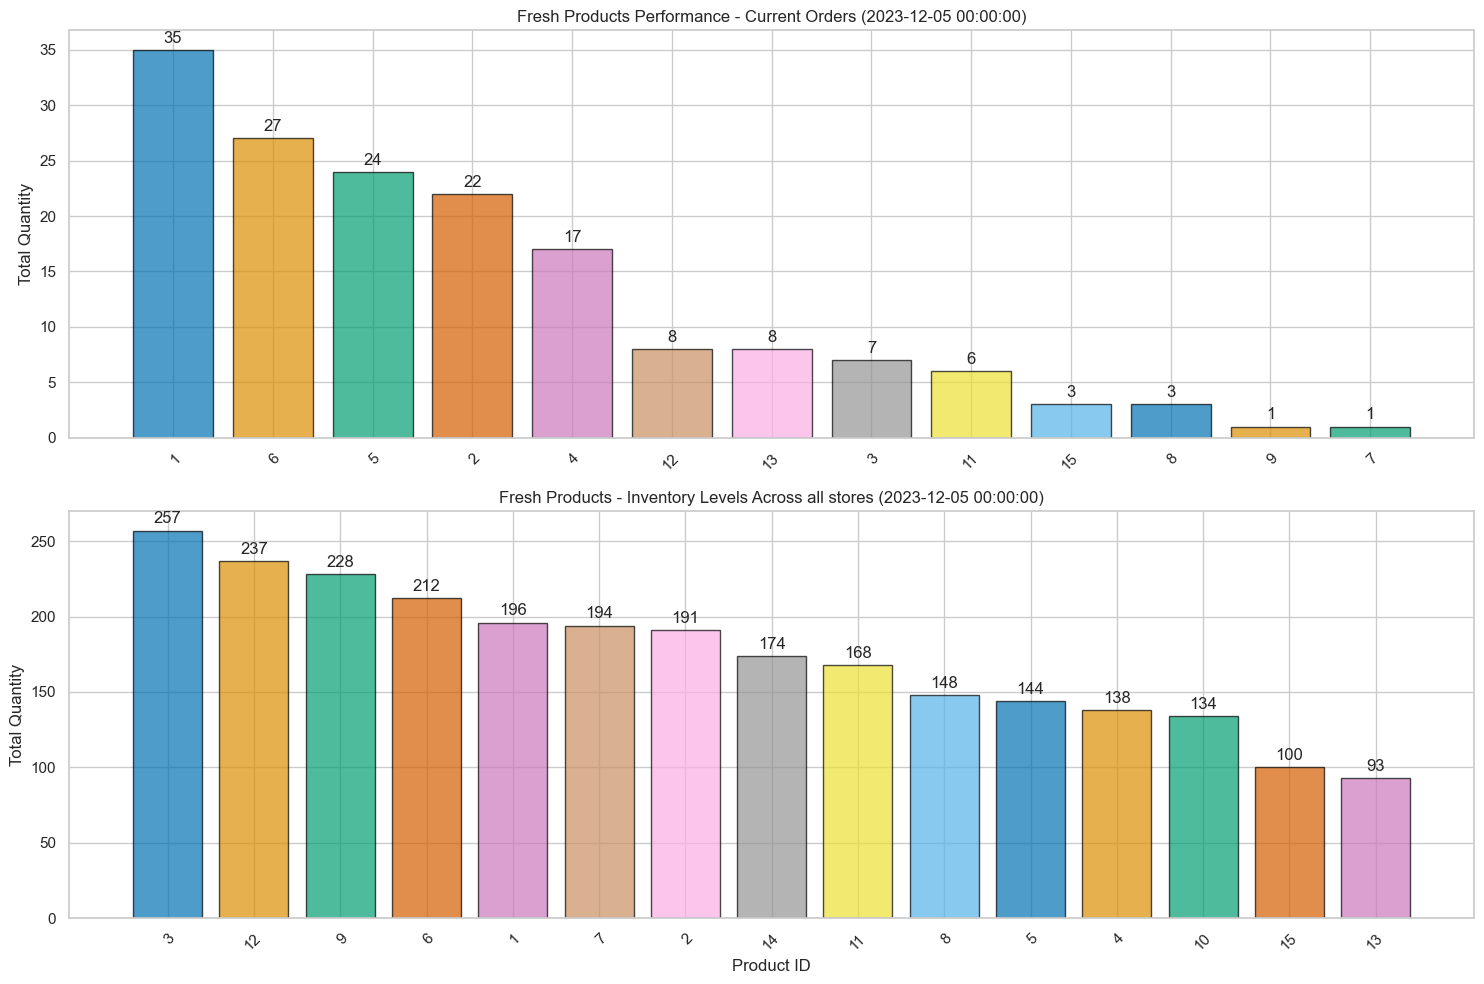

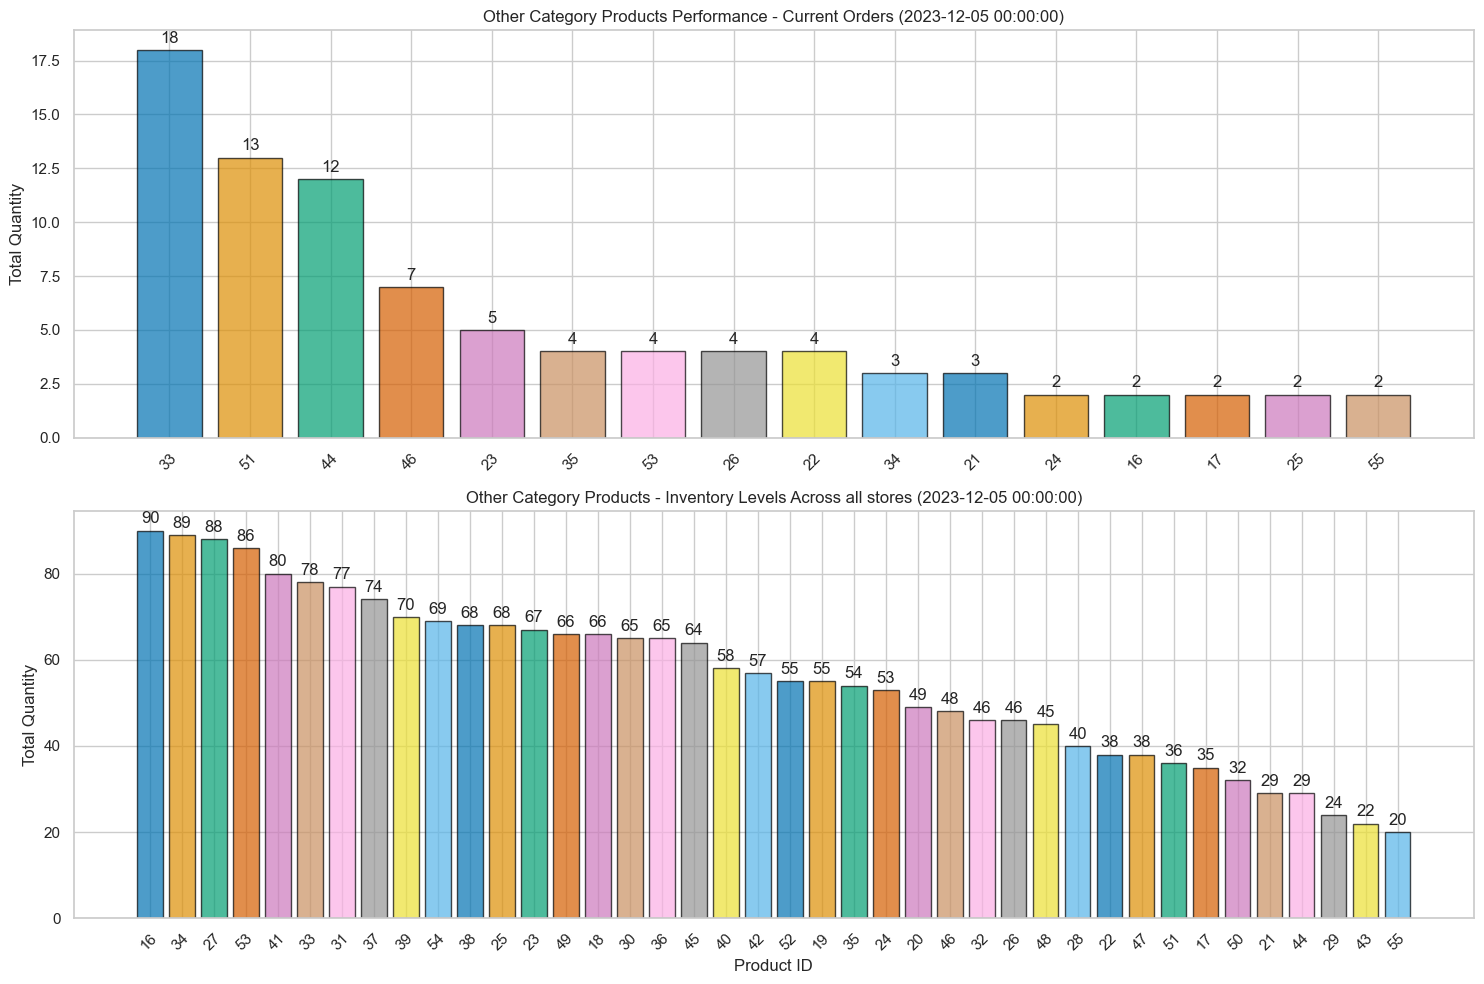

In [7]:
# using it on our sample data
date = datetime(2023, 12, 5) 
generate_product_performance_plot(date)


## end of query